In [1]:
import numpy as np
import h5py
import treecorr

In [2]:
def apply_metacal_response(R, S, g1, g2):
    # The values of R are assumed to already
    # have had appropriate weights included
    from numpy.linalg import pinv
    import numpy as np

    mcal_g = np.stack([g1, g2], axis=1)

    R_total = R + S

    # Invert the responsivity matrix
    Rinv = pinv(R_total)
    mcal_g = Rinv @ mcal_g.T

    return mcal_g[0], mcal_g[1]

In [3]:
# Load tomography data
path1 = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/'
path2 = '../../TXPipe/data/desy3/outputs/'
with h5py.File(path2+'shear_tomography_catalog.hdf5','r') as f:
    source_bin = f['tomography/bin'][:]
    mask = source_bin != -1  # Only use the sources that pass the fiducial cuts
    R_total_2d = f['response/R_S_2d'][:] + f['response/R_gamma_mean_2d'][:]

with h5py.File(path1+'shear_catalog_desy3_unmasked_withfakez.hdf5','r') as f:
    g = f['shear']
    g1      = g['mcal_g1'][:][mask]
    g2      = g['mcal_g2'][:][mask]
    gw  = g['weight'][:][mask]
    gra,gdec = g['ra'][:][mask], g['dec'][:][mask]

print('Applying metacal/metadetect response')
g1, g2 = apply_metacal_response(R_total_2d, 0.0, g1, g2)


gg = np.array((g1, g2))


Applying metacal/metadetect response


In [4]:
with h5py.File(path1+"DES_psf_y3_catalog.hdf5",'r') as f:
    g      = f["stars"]
    reserved = g["calib_psf_reserved"][:].astype('int')
    sra     = g["ra"][reserved==1][:]
    sdec    = g["dec"][reserved==1][:]
    e1psf  = g["measured_e1"][reserved==1][:]
    e2psf  = g["measured_e2"][reserved==1][:]
    e1mod  = g["model_e1"][reserved==1][:]
    e2mod  = g["model_e2"][reserved==1][:]
    de1    = e1psf - e1mod
    de2    = e2psf - e2mod

    T_f = (g["measured_T"][reserved==1][:] - g["model_T"][reserved==1][:]) / g["measured_T"][reserved==1][:]

    e_psf  = np.array((e1psf, e2psf))
    e_mod  = np.array((e1mod,e2mod))
    de_psf = np.array((de1, de2))


In [5]:
p = e_mod
q = de_psf
w = e_psf * T_f

In [6]:
print(f"Computing Tau 0,2,5 and the covariance")

# Load all catalogs
catg = treecorr.Catalog(ra=gra, dec=gdec, g1=gg[0], g2=gg[1], w=gw, ra_units="deg", dec_units="deg",npatch=40) # galaxy shear
catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0], g2=p[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0], g2=q[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
catw = treecorr.Catalog(ra=sra, dec=sdec, g1=w[0], g2=w[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_*(T_* - T_model)/T_* )

# Compute all corrleations
corr0 = treecorr.GGCorrelation(min_sep       = 0.5,
                               max_sep       = 250.0,
                               nbins         = 20,
                               bin_slop      = 0.01,
                               sep_units     = "arcmin",
                               var_method    = 'bootstrap')
corr0.process(catg, catp)
corr2 = treecorr.GGCorrelation( min_sep       = 0.5,
                                max_sep       = 250.0,
                                nbins         = 20,
                                bin_slop      = 0.01,
                                sep_units     = "arcmin",
                                var_method    = 'bootstrap')
corr2.process(catg, catq)
corr5 = treecorr.GGCorrelation( min_sep       = 0.5,
                                max_sep       = 250.0,
                                nbins         = 20,
                                bin_slop      = 0.01,
                                sep_units     = "arcmin",
                                var_method    = 'bootstrap')
corr5.process(catg, catw)

Computing Tau 0,2,5 and the covariance


In [7]:
cov = treecorr.estimate_multi_cov([corr0,corr2,corr5], 'bootstrap')

# For our particular purpose, we only care about xip so can remove the xim elements. 
nbins = 20
idx = [i + j for i in range(nbins, 6*nbins, nbins * 2) for j in range(nbins) if i + j < 6*nbins]
cov = np.delete(cov,idx,axis=0)
cov = np.delete(cov,idx,axis=1)

# Get both theta and xip
tht0,xip0 = corr0.meanr, corr0.xip
tht2,xip2 = corr2.meanr, corr2.xip
tht5,xip5 = corr5.meanr, corr5.xip

In [8]:
nb    = len(tht0)

errs  = {0: np.diag(cov[int(0*nb):int(1*nb),int(0*nb):int(1*nb)])**0.5,
                     2: np.diag(cov[int(1*nb):int(2*nb),int(1*nb):int(2*nb)])**0.5,
                     5: np.diag(cov[int(2*nb):int(3*nb),int(2*nb):int(3*nb)])**0.5
                    }

Text(0, 0.5, '$\\theta \\times \\tau_{5}$')

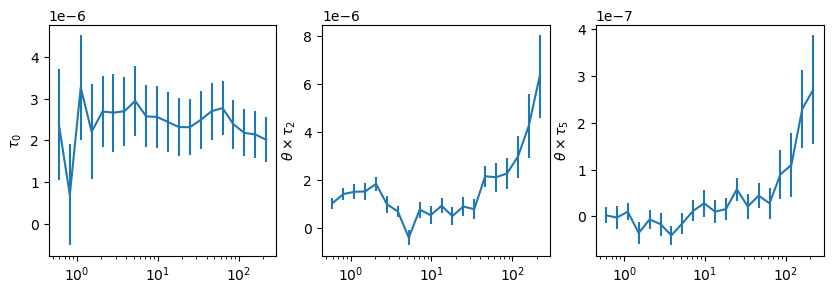

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=[10,3])
ax1,ax2,ax3 = axs.flatten()
ax1.errorbar(tht0,xip0,np.diag(cov[int(0*nb):int(1*nb),int(0*nb):int(1*nb)])**0.5)
ax1.set_xscale('log')
ax1.set_ylabel(r'$\tau_{0}$')

ax2.errorbar(tht2,tht2*xip2,tht2*np.diag(cov[int(1*nb):int(2*nb),int(1*nb):int(2*nb)])**0.5)
ax2.set_xscale('log')
ax2.set_ylabel(r'$\theta \times \tau_{2}$')

ax3.errorbar(tht5,tht5*xip5,tht5*np.diag(cov[int(2*nb):int(3*nb),int(2*nb):int(3*nb)])**0.5)
ax3.set_xscale('log')
ax3.set_ylabel(r'$\theta \times \tau_{5}$')



In [12]:
desy3tau = h5py.File('../../TXPipe/data/desy3/outputs/tau_stats.hdf5','r')

covdesy3 = desy3tau['tau_statistics/tau_PSF-reserved/cov'][:]
nb    = len(desy3tau['tau_statistics/tau_PSF-reserved/theta'][:])

errs  = {'desy3_0': np.diag(covdesy3[int(0*nb):int(1*nb),int(0*nb):int(1*nb)])**0.5,
         'desy3_2': np.diag(covdesy3[int(1*nb):int(2*nb),int(1*nb):int(2*nb)])**0.5,
         'desy3_5': np.diag(covdesy3[int(2*nb):int(3*nb),int(2*nb):int(3*nb)])**0.5,
        }

Text(0, 0.5, '$\\theta \\times \\tau_{5}$')

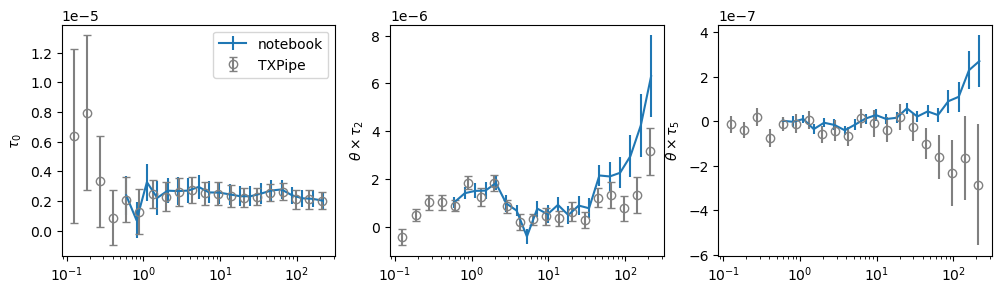

In [18]:
fig, axs = plt.subplots(1,3,figsize=[12,3])
ax1,ax2,ax3 = axs.flatten()
ax1.errorbar(tht0,xip0,np.diag(cov[int(0*nb):int(1*nb),int(0*nb):int(1*nb)])**0.5,label='notebook')
ax1.errorbar(desy3tau['tau_statistics/tau_PSF-reserved/theta'][:],
             desy3tau[f'tau_statistics/tau_PSF-reserved/tau0'][:],
             errs[f'desy3_0'],
             color='grey',marker='o',mfc='None',ls='None',capsize=3,label='TXPipe')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\tau_{0}$')
ax1.legend()

ax2.errorbar(tht2,tht2*xip2,tht2*np.diag(cov[int(1*nb):int(2*nb),int(1*nb):int(2*nb)])**0.5)
ax2.errorbar(desy3tau['tau_statistics/tau_PSF-reserved/theta'][:],
             desy3tau['tau_statistics/tau_PSF-reserved/theta'][:]*desy3tau[f'tau_statistics/tau_PSF-reserved/tau2'][:],
             desy3tau['tau_statistics/tau_PSF-reserved/theta'][:]*errs[f'desy3_2'],
             color='grey',marker='o',mfc='None',ls='None',capsize=3,label='TXPipe')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\theta \times \tau_{2}$')

ax3.errorbar(tht5,tht5*xip5,tht5*np.diag(cov[int(2*nb):int(3*nb),int(2*nb):int(3*nb)])**0.5)
ax3.errorbar(desy3tau['tau_statistics/tau_PSF-reserved/theta'][:],
             desy3tau['tau_statistics/tau_PSF-reserved/theta'][:]*desy3tau[f'tau_statistics/tau_PSF-reserved/tau5'][:],
             desy3tau['tau_statistics/tau_PSF-reserved/theta'][:]*errs[f'desy3_5'],
             color='grey',marker='o',mfc='None',ls='None',label='TXPipe')

ax3.set_xscale('log')
ax3.set_ylabel(r'$\theta \times \tau_{5}$')